In [1]:
import pandas as pd
import numpy as np

import pickle
import os
import random
from collections import defaultdict

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []
    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [7]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros(batch_size, dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

def build_frequencies(all_codones, dictionary):
    flat_codones = flatten(all_codones)
    word_frequency = defaultdict(lambda: 0)
    for codone in flat_codones:
        word_frequency[dictionary[codone]] += 1
    return word_frequency

In [8]:
dictionary = make_dictionary(all_codones)

In [9]:
word_frequency = build_frequencies(all_codones, dictionary)

In [10]:
def build_sample_table(word_frequency):
    '''
    Building a list of word indexes assuming unigram (raised to the 
    3/4rd power) distribution of words.
    '''
    sample_table = []
    sample_table_size = 1e6
    pow_frequency = np.array(list(word_frequency.values()))**0.75
    words_pow = sum(pow_frequency)
    ratio = pow_frequency / words_pow
    count = np.round(ratio * sample_table_size)
    for wid, c in enumerate(count):
        sample_table += [wid] * int(c)
    return np.array(sample_table)

sample_table = build_sample_table(word_frequency)

In [11]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [16]:
class SkipGramModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.u_embeddings = nn.Embedding(vocab_size, embed_size) # Embeddings for central positions
        self.v_embeddings = nn.Embedding(vocab_size, embed_size) # Embeddings for target positions
        
        eps = 0.5 / self.embed_size
        self.u_embeddings.weight.data.uniform_(-eps, eps)
        self.v_embeddings.weight.data.uniform_(-0, 0)
                  
    def forward(self, pos_u, pos_v, neg_v):
        embeds_u = self.u_embeddings(pos_u)
        embeds_v = self.v_embeddings(pos_v)
        pos_score = torch.mul(embeds_u, embeds_v).squeeze().sum(dim=1)
        pos_score = F.logsigmoid(pos_score)
        
        neg_emb_v = self.v_embeddings(neg_v)
        neg_score = torch.bmm(neg_emb_v, embeds_u.unsqueeze(2)).squeeze()
        neg_score = F.logsigmoid(-1 * neg_score)
        return -1 * (torch.sum(pos_score) + torch.sum(neg_score))

In [17]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100      # Dimension of the word embedding vectors
NUM_SAMPLED = 5       # Number of negative examples to sample.
LEARNING_RATE = .025
NUM_TRAIN_STEPS = 500000
SKIP_STEP = 25000

def train_embeddings(batch_gen):        
    torch.manual_seed(1)
    np.random.seed(1)
    
    cuda_available = torch.cuda.is_available()

    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE)
    if cuda_available:
        model = model.cuda()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
    for step in range(1, NUM_TRAIN_STEPS + 1):
        centers, targets = next(batch_gen)
        pos_u = centers
        pos_v = targets
        neg_v = np.random.choice(VOCAB_SIZE, size=(len(centers), NUM_SAMPLED))
    
        pos_u = torch.tensor(pos_u, dtype=torch.long)
        pos_v = torch.tensor(pos_v, dtype=torch.long)
        neg_v = torch.tensor(neg_v, dtype=torch.long)
        if cuda_available:
            pos_u = pos_u.cuda()
            pos_v = pos_v.cuda()
            neg_v = neg_v.cuda()

        optimizer.zero_grad()
        loss = model.forward(pos_u, pos_v, neg_v)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if step % SKIP_STEP == 0:
            print('Average loss at step {}: {:5.1f}'.format(step, total_loss / SKIP_STEP))
            total_loss = 0.0
    
    if cuda_available:
        embedding = self.u_embeddings.weight.cpu().data.numpy()
    else:
        embedding = self.u_embeddings.weight.data.numpy()
    return embedding

In [157]:
final_embed_matrix = read_or_create(read_path='data/embeddings.pickle',
                                    producer=lambda: train_embeddings(batch_gen))

Average loss at step 25000: 267.8
Average loss at step 50000: 205.5
Average loss at step 75000: 214.1
Average loss at step 100000: 227.7
Average loss at step 125000: 200.1
Average loss at step 150000: 182.5
Average loss at step 175000: 258.5
Average loss at step 200000: 254.5
Average loss at step 225000: 257.5
Average loss at step 250000: 265.3
Average loss at step 275000: 269.5
Average loss at step 300000: 263.2
Average loss at step 325000: 253.1
Average loss at step 350000: 248.0
Average loss at step 375000: 244.8
Average loss at step 400000: 210.4
Average loss at step 425000: 187.3
Average loss at step 450000: 210.1
Average loss at step 475000: 195.0
Average loss at step 500000: 205.4
saving data/embeddings.pickle


In [158]:
######################

In [160]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,-7.264315,4.320916,AVG
1,-7.713467,-0.566269,PDK
2,-1.902404,11.353946,AFT
3,-14.357402,-51.349602,DXW
4,16.375324,2.338462,PCD


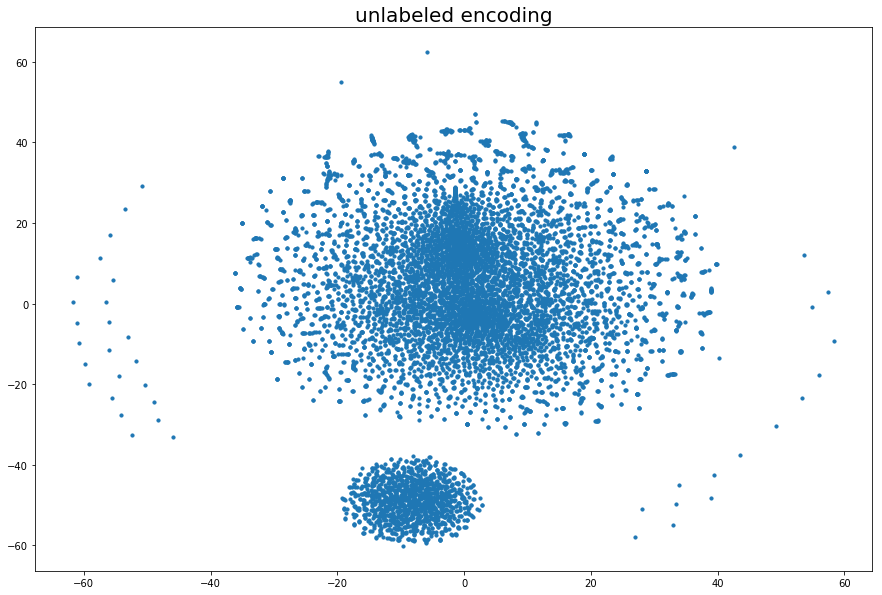

In [161]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()
    
plot_tsne_df(tsne_df)

In [162]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [163]:
######################

In [164]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [165]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [166]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,QTE,-2.566667,119.449033,18.666667,132.766667
1,PGN,-1.833333,89.423033,14.666667,95.633333
2,EGC,-0.466667,96.436067,14.333333,102.333333
3,RTD,-2.900000,124.125667,19.666667,133.533333
4,NEM,-1.700000,124.804233,18.666667,138.466667


In [167]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,QTE,-2.566667,119.449033,18.666667,132.766667,-1.087662,16.866877
1,PGN,-1.833333,89.423033,14.666667,95.633333,6.197362,13.930958
2,EGC,-0.466667,96.436067,14.333333,102.333333,-10.167870,3.526900
3,RTD,-2.900000,124.125667,19.666667,133.533333,2.553796,9.836115
4,NEM,-1.700000,124.804233,18.666667,138.466667,-11.657272,13.378279


In [168]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

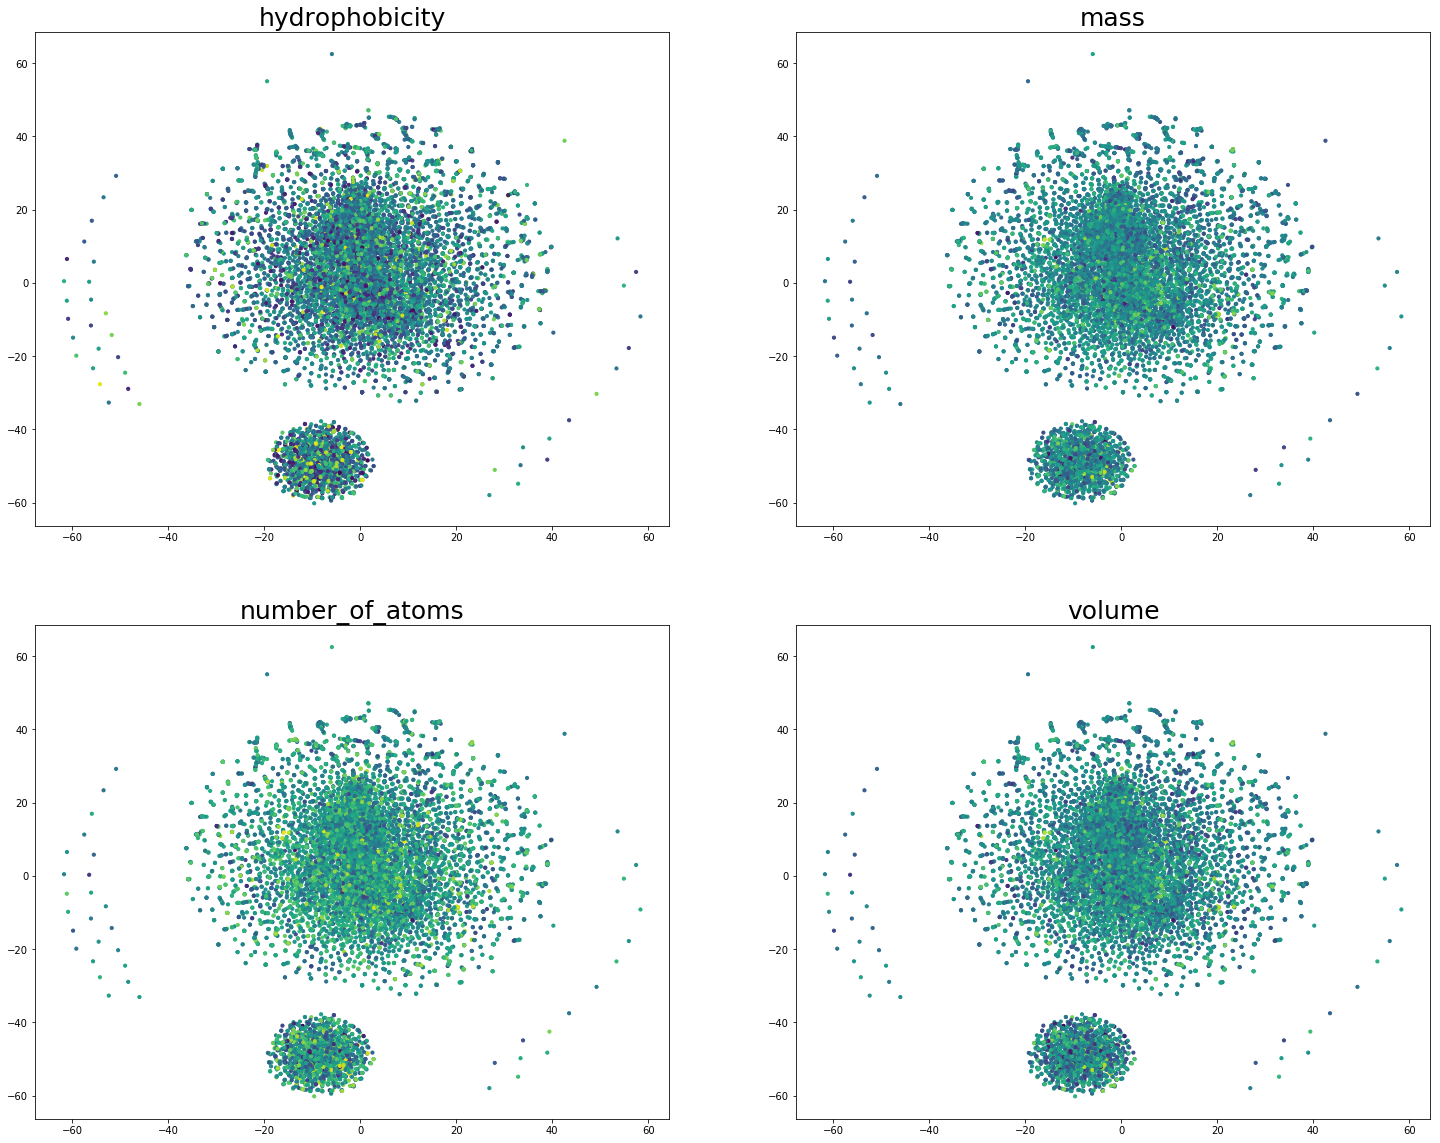

In [169]:
plot_embedding_properties(final_df)

In [170]:
######################

In [171]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

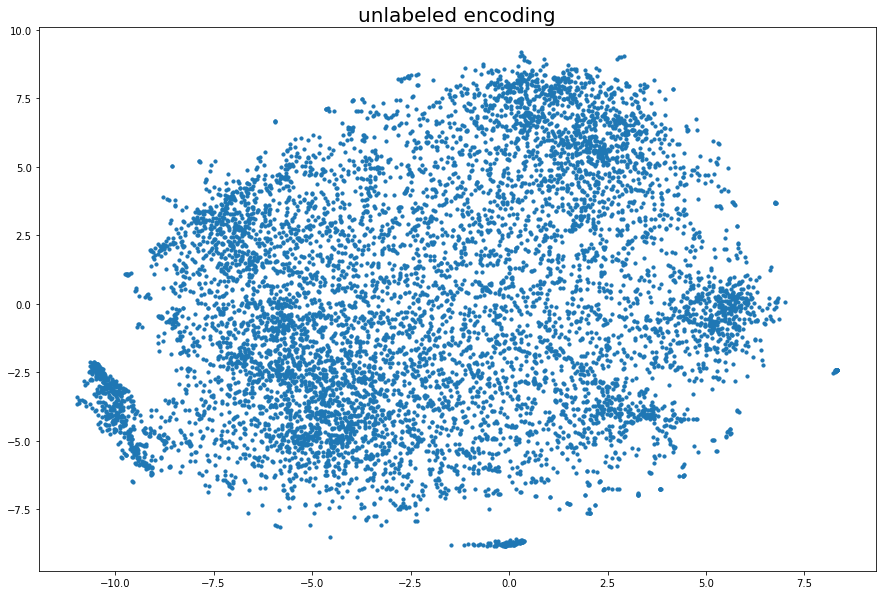

In [172]:
plot_tsne_df(gensim_tsne_df)

In [173]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

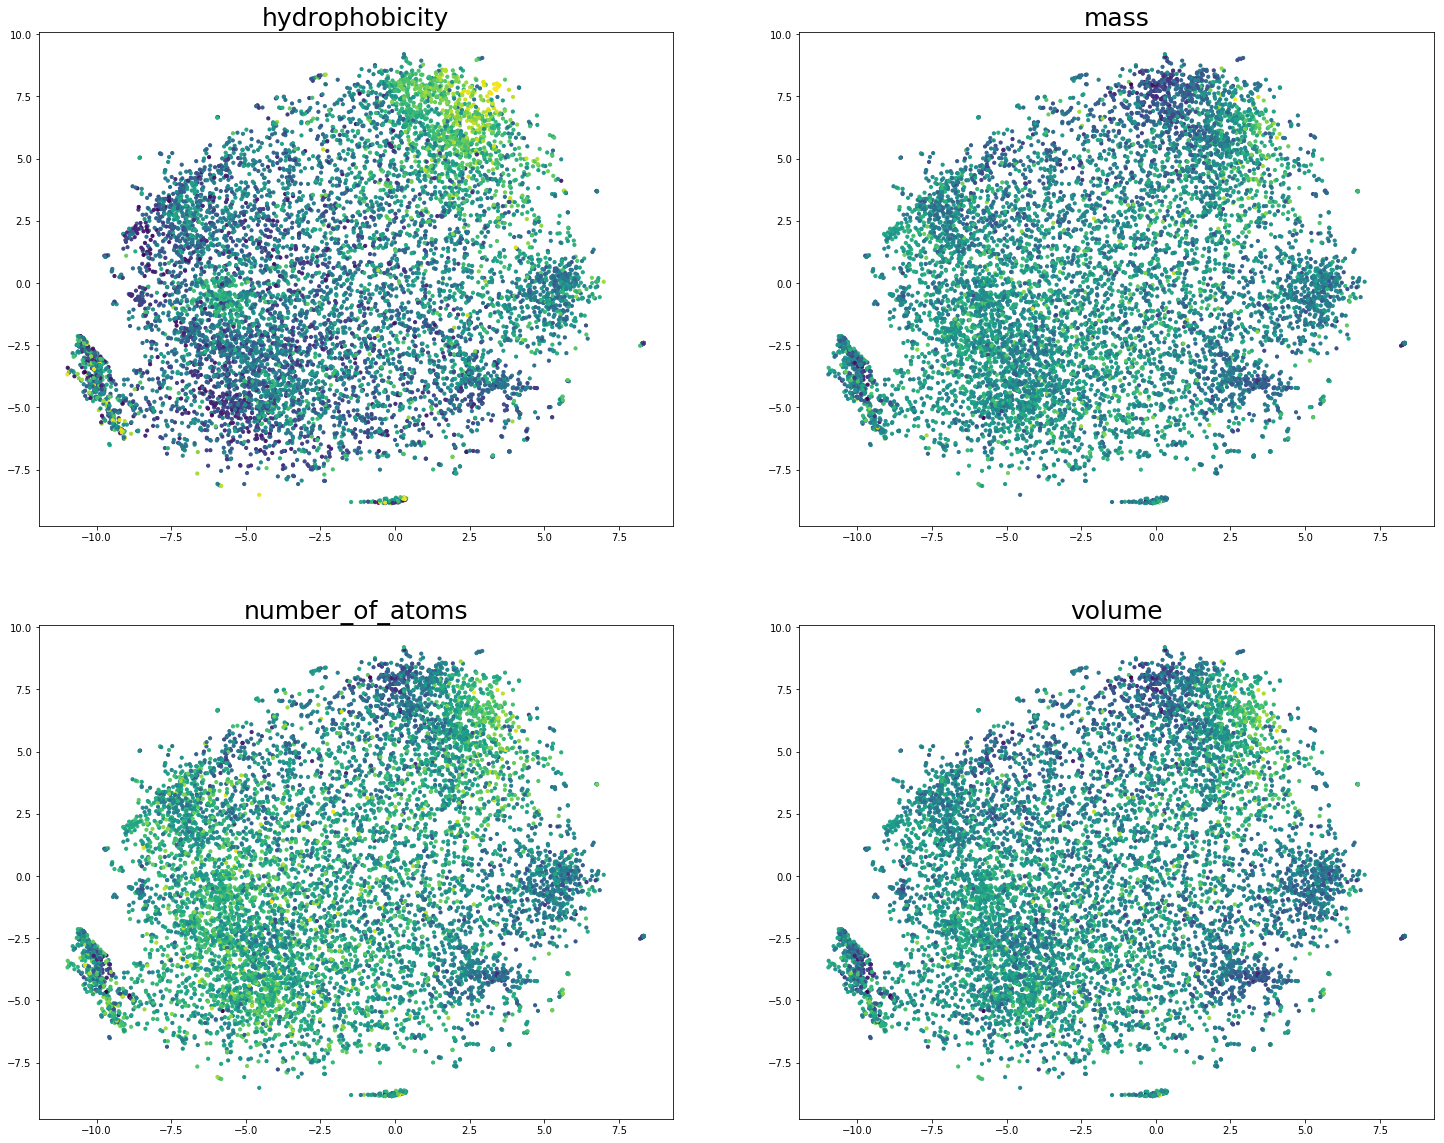

In [174]:
plot_embedding_properties(final_df_nice)

In [187]:
from tensorboardX import SummaryWriter

writer = SummaryWriter(log_dir='visual/')
writer.add_embedding(final_embed_matrix, tag="embeddings")
writer.close()

Then run tensorboard:
```
tensorboard --logdir visual/
```
And navigate to Projector -> T-SNE -> 3D and enjoy watching!

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59